---

# DoH

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from load_data import get_DoH

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    
    
def plotLoss(losses, d_losses_val, p_true, p_fake, rec_errors, kldes, real_scores, fake_scores, i, DATASET, show = False):
    num_epochs = len(losses)
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), losses[:num_epochs], label='$\mathcal{L}$')  
    
    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_losses_{DATASET}.pdf')
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    
    plt.plot(range(1, num_epochs + 1), p_true[:num_epochs], 'y', label=r'$\mathbb{E}_{x}\left[\log p_{\theta} (1|x)\right]$')
    plt.plot(range(1, num_epochs + 1), p_fake[:num_epochs], 'green', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p(0|\tilde{x})\right]$')
    plt.plot(range(1, num_epochs + 1), rec_errors[:num_epochs], 'magenta', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p_{\theta} (x|\tilde{x})\right]$')     
    plt.plot(range(1, num_epochs + 1), kldes[:num_epochs], 'red', label=r'$\mathbb{KLD}$') 

    plt.yscale('log')
    plt.legend(loc = 'lower right', bbox_to_anchor=(.9, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_gen_loss_{DATASET}.pdf')  
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.ylim(0, 1)
    plt.plot(range(1, num_epochs + 1), fake_scores[:num_epochs], label='fake score')
    plt.plot(range(1, num_epochs + 1), real_scores[:num_epochs], label='real score')    

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_score_{DATASET}.pdf') 
        


        

def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)


def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = torch.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return torch.softmax(y / temperature, dim=-1).to(device)


def gumbel_softmax(logits, temperature=1e-5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y


def gumbel_sigmoid_sample(logits, temperature):
    # See https://davidstutz.de/categorical-variational-auto-encoders-and-the-gumbel-trick/
    u = torch.rand_like(logits)
    # we exploit the fact log(sigma(x)) - log(1-sigma(x)) = x
    y = logits + torch.log(u) - torch.log(1 - u)
    
    return torch.sigmoid(y / temperature)


def gumbel_sigmoid(logits, temperature=1e-5):
    """
    input: [*]
    return: [*] a binary response
    """
    y = gumbel_sigmoid_sample(logits, temperature)
    y_hard = (y > .5).float()
    return (y_hard - y).detach() + y


class Generator(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Generator, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), 
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.nf_out, self.nf_out * 2),
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.nf_out * 2, self.nf_in)
        )

        self.fc1 = nn.Linear(self.nf_out, self.nf_out)
        self.fc21 = nn.Linear(self.nf_out, self.z_dim)
        self.fc22 = nn.Linear(self.nf_out, self.z_dim)

        self.fc3 = nn.Linear(self.z_dim, self.nf_out)
        self.fc4 = nn.Linear(self.nf_out, self.nf_out)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc21(h), self.fc22(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        conv = self.encoder(x)
        h = self.fc1(conv)
        
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        h = self.relu(self.fc3(z))
        deconv_input = self.fc4(h)
        
        return self.decoder(deconv_input)
    
    def gumbel(self, logits, t):
        return gumbel_softmax(logits, t)

    def forward(self, x, text_l, selected_columnsTrain, index, t=1):
        z, mu, logvar = self.encode(x)
        logits = self.decode(z)
        
        sampled_data = logits.clone()
        sampled_data[:, index] = self.sigmoid(logits[:, index])
        for name in text_l:
            sampled_data[:, selected_columnsTrain[name]] = self.gumbel(logits[:, selected_columnsTrain[name]], t)
        
        return logits, mu, logvar, sampled_data
    
class Discriminator(nn.Module):

    def __init__(self, nc = 121, nf_out = 16, nout = 128):
        super(Discriminator, self).__init__()
        
        self.nc = nc
        self.nf_out = nf_out
        self.nout = nout
        
        self.main = nn.Sequential(
            # features extractor
            nn.Linear(self.nc, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout, self.nout * 2),
            nn.BatchNorm1d(self.nout * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout * 2, self.nout * 4),
            nn.BatchNorm1d(self.nout * 4, track_running_stats = False),
            nn.LeakyReLU(0.2),

            # classifier
            nn.Linear(self.nout * 4, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.ReLU(),

            nn.Linear(self.nout, self.nf_out * 4),
            nn.BatchNorm1d(self.nf_out * 4, track_running_stats = False),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 4, self.nf_out * 2),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out, 1),
            nn.Sigmoid()
        )
        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):
        x = self.main(x)
        return x.flatten()
    

class Loss(nn.Module):
    def __init__(self, device, text_l, selected_columnsTrain, index):
        super(Loss, self).__init__()
        self.device = device
        
        self.text_l = text_l
        self.selected_columnsTrain = selected_columnsTrain
        self.index = index
        
        self.bce = nn.BCELoss() 
        self.mse = nn.MSELoss()
        self.cel = nn.CrossEntropyLoss()
        
        
    def KLD(self,z_mean, z_logvar):
        return torch.mean(0.5 * (-0.5 * z_logvar + torch.exp(0.5 * z_logvar) + z_mean ** 2))
        

    def reconstruction(self, true_data, sampled_data):
        g1 = self.mse(true_data[:, self.index], sampled_data[:, self.index])
        g2 = 0
        for name in self.text_l:
            y = true_data[:, self.selected_columnsTrain[name]]
            y_p = sampled_data[:, self.selected_columnsTrain[name]]
            g2 += self.mse(y_p, y)
        g2 /= len(self.text_l)
        return g1 + 0.5 * g2
        
    def forward(self, true_data, sampled_data, z_mean, z_logvar, true_pred, fake_pred, step, alpha = 20):
        bs = true_pred.size(0)
        
        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(self.device)
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(self.device)
        
        log_p_true = self.bce(true_pred, y_real)
        log_p_fake = self.bce(fake_pred, y_fake)
        
        reconstruction = self.reconstruction(true_data, sampled_data)
        kld = self.KLD(z_mean, z_logvar)
        
        return log_p_true + log_p_fake + alpha*reconstruction + kld, log_p_true, log_p_fake, reconstruction, kld
    
  
    
    
    
class AADNet(nn.Module):
    def __init__(self, device, selected_columns, discreteCol, index, nc):
        super(AADNet, self).__init__()
        self.device = device
        self.selected_columns = selected_columns
        self.discreteCol = discreteCol
        self.index = index
        self.nc = nc

        self.D = Discriminator(nc = self.nc).to(self.device)
        self.G = Generator(nf_in = self.nc).to(self.device)

        self.optimizer = torch.optim.Adam([
            {'params': self.D.parameters(), 'lr': 1e-5},
            {'params': self.G.parameters(), 'lr': 1e-4}
        ])
        
        self.loss = Loss(self.device, self.discreteCol, self.selected_columns, self.index)
        
        self.temperature = 1
        self.anneal = 0.9995
        
        self.criterion = nn.BCELoss()
        

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
    
            
    def evaluation(self, test_loader):
        self.D.eval()
        
        d_l = []
        ind = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
                d_loss_batch = self.criterion(y_pred, label)
                
            d_l.append(d_loss_batch.item())
        
        return np.mean(d_l)
    
    def predict(self, test_loader):
        self.D.eval()
        i = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
            if i == 0:
                prediction = y_pred.cpu().round()
                y_true = label.cpu()
                yP = y_pred.cpu()
            else:
                prediction = torch.cat((prediction, y_pred.cpu().round()))
                y_true = torch.cat((y_true, label.cpu()))
                yP = torch.cat((yP, y_pred.cpu()))
                
            i += 1
            
        return prediction, y_true, yP
        
        
    def train(self, data_loader, test_loader, name_d, name_g, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        
        losses = np.zeros(num_epochs)
        p_true = np.zeros(num_epochs)
        p_fake = np.zeros(num_epochs)
        rec_errors = np.zeros(num_epochs)
        kldes = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        
        d_losses_val = np.zeros(num_epochs)
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        minloss = np.Inf
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                self.D.train()
                self.G.train()
                i = 0
                for batch in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)

                    logits, z_mean, z_logvar, sampled_data = self.G(batch, self.discreteCol, self.selected_columns, self.index, self.temperature)
                    
                    true_pred = self.D(batch)
                    fake_pred = self.D(sampled_data)
                    
                    _loss, log_p_true, log_p_fake, reconstruction, kld = self.loss(batch, logits, z_mean, z_logvar, true_pred, fake_pred, step_count)
                    _loss.backward()
                    self.optimizer.step()
                    
                    
                    losses[epoch] = losses[epoch]*(i/(i+1.)) + _loss.item()*(1./(i+1.))
                    rec_errors[epoch] = rec_errors[epoch]*(i/(i+1.)) + reconstruction.item()*(1./(i+1.)) 
                    kldes[epoch] = kldes[epoch]*(i/(i+1.)) + kld.item()*(1./(i+1.))
                    p_true[epoch] = p_true[epoch]*(i/(i+1.)) + log_p_true.item()*(1./(i+1.))
                    p_fake[epoch] = p_fake[epoch]*(i/(i+1.)) + log_p_fake.item()*(1./(i+1.))
                    
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + true_pred.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_pred.mean().item()*(1./(i+1.))


                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    i += 1
                    
                if losses[epoch] < minloss:    
                    minloss = losses[epoch]
                    torch.save(self.D.state_dict(), os.path.join(SPACE_MODELS, name_d))
                    torch.save(self.G.state_dict(), os.path.join(SPACE_MODELS, name_g))
                
                dLossVal = self.evaluation(test_loader)
                
                d_losses_val[epoch] = dLossVal
               
                sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | loss: {:.4f} ({:.4f}, {:.4f}, {:.4f}, {:.4f}) | D(x): {:.2f} | D(G(x)): {:.2f} |  d_loss_val: {:.4f} |'
                              .format(epoch+1, num_epochs, losses[epoch], p_true[epoch], p_fake[epoch], rec_errors[epoch], kldes[epoch], real_scores[epoch], fake_scores[epoch], d_losses_val[epoch]))
                sys.stdout.flush()
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        return losses[:epoch], p_true[:epoch],p_fake[:epoch], rec_errors[:epoch], kldes[:epoch], real_scores[:epoch], fake_scores[:epoch], d_losses_val[:epoch]
    

In [3]:
batch_size = 1024

WORK_SPACE = '../Dataset'
DATASET_AREA = 'CIRA-CIC-DoHBrw-2020'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)

FILE_3 = 'l2-benign.csv'
FILE_4 = 'l2-malicious.csv'

DATASET = 'DoH'

PATH_B = os.path.join(WORK_SPACE, DATASET_AREA, FILE_3)
PATH_M = os.path.join(WORK_SPACE, DATASET_AREA, FILE_4)

In [4]:
dataset = get_DoH(PATH_B, PATH_M, seed, show=True)

19807 normal records, 249836 anormal records
We use 124918 anomalous records
-----------------------------------------------------------------------------------------
There are 15846 records in training set
Training set is composed by 15846 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 7236 records in validation set
Validation set is composed by 990 normal records and 6246 abnormal records
-----------------------------------------------------------------------------------------
There are 21709 records in test set
Test set is composed by 2971 normal records and 18738 abnormal records


#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.3770 (0.0027, 0.0037, 0.0400, 0.5706) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2546 |
[INFO] Training phase... Elapsed time: 1790 seconds



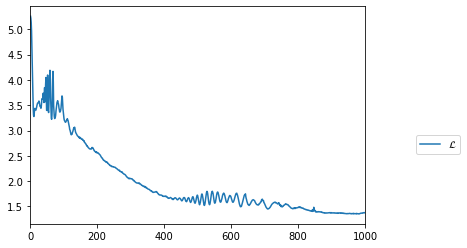

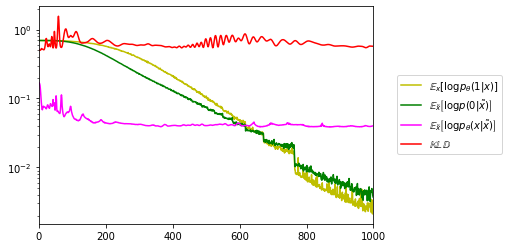

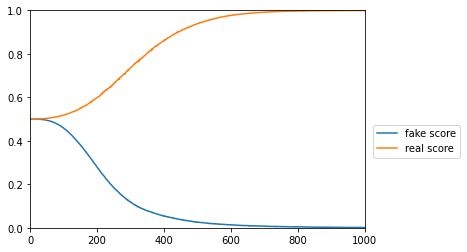

PR AUC: 1.00


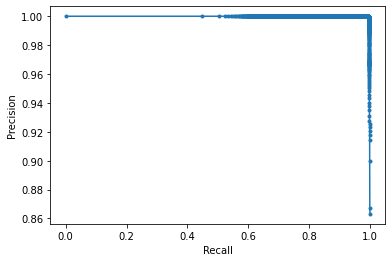

AUC: 1.00
Iteration: 2
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.4198 (0.0023, 0.0038, 0.0428, 0.5582) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 2.5841 |
[INFO] Training phase... Elapsed time: 1800 seconds



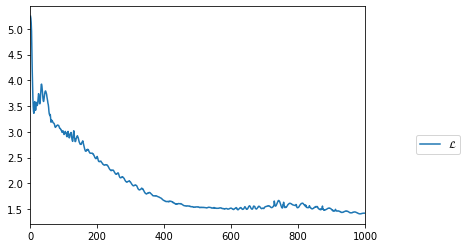

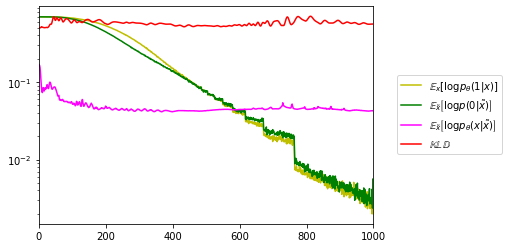

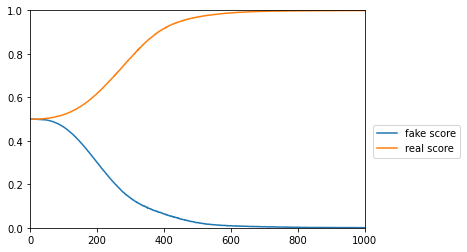

PR AUC: 1.00


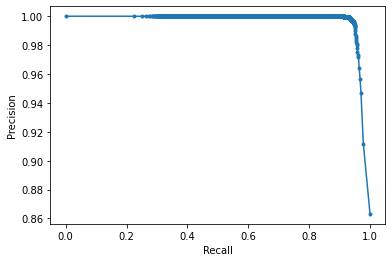

AUC: 0.97
Iteration: 3
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.5452 (0.0031, 0.0058, 0.0407, 0.7216) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 1.0668 |
[INFO] Training phase... Elapsed time: 1805 seconds



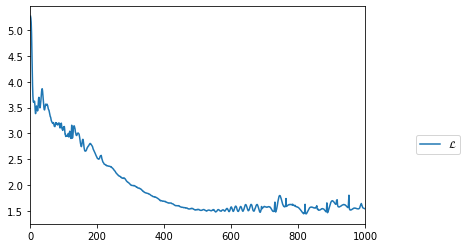

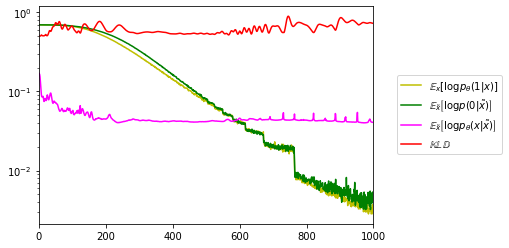

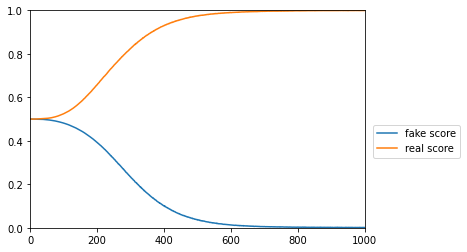

PR AUC: 1.00


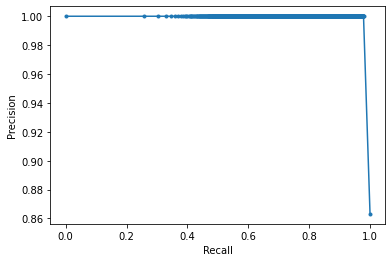

AUC: 0.99
Iteration: 4
[INFO] Starting training phase...
Epoch [234/1000] | loss: 2.3181 (0.4282, 0.4097, 0.0454, 0.5725) | D(x): 0.70 | D(G(x)): 0.28 |  d_loss_val: 0.3732 |

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [1000/1000] | loss: 1.4544 (0.0050, 0.0135, 0.0445, 0.5454) | D(x): 1.00 | D(G(x)): 0.01 |  d_loss_val: 1.5421 |
[INFO] Training phase... Elapsed time: 1384 seconds



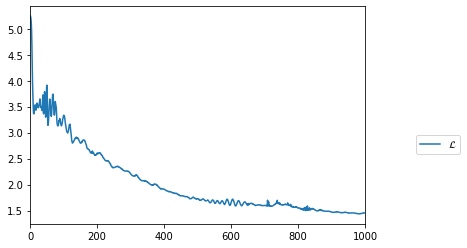

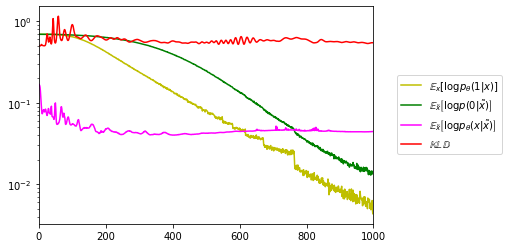

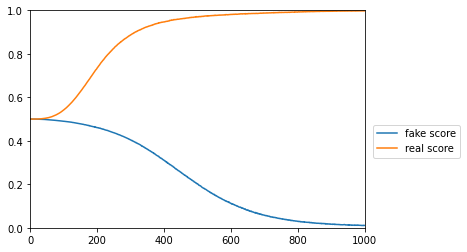

PR AUC: 1.00


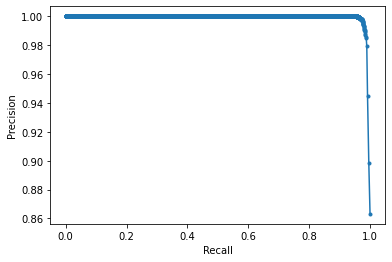

AUC: 0.99
Iteration: 9
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.4914 (0.0026, 0.0031, 0.0387, 0.7114) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 1.1311 |
[INFO] Training phase... Elapsed time: 1384 seconds



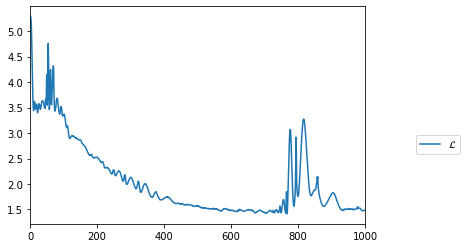

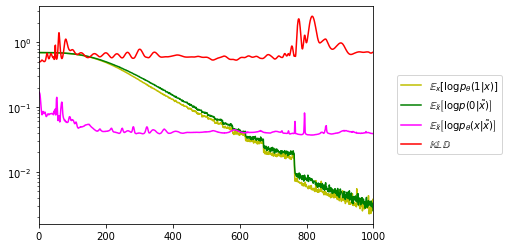

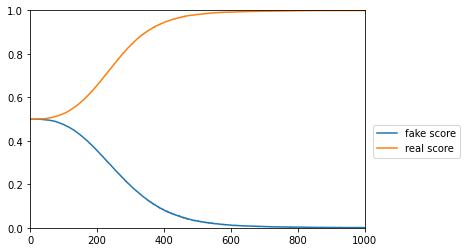

PR AUC: 1.00


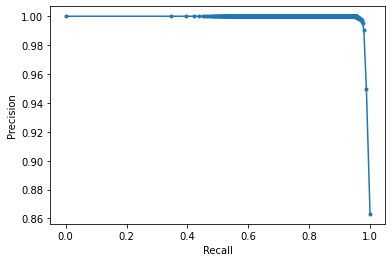

AUC: 0.99
Iteration: 10
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.7401 (0.0027, 0.0051, 0.0390, 0.9527) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2932 |
[INFO] Training phase... Elapsed time: 1360 seconds



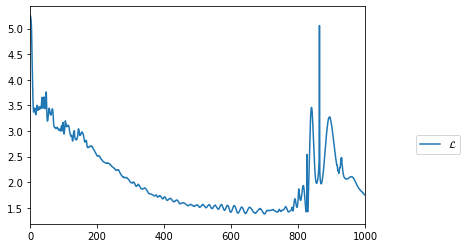

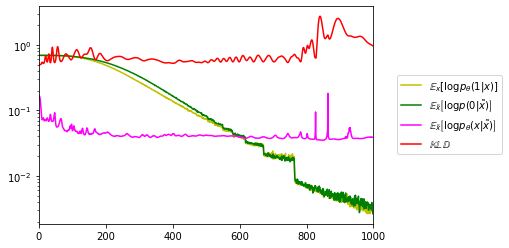

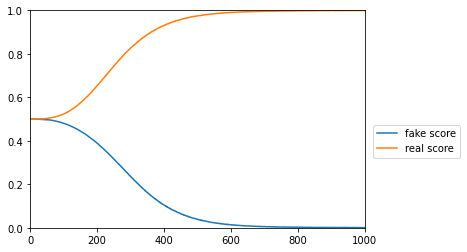

PR AUC: 1.00


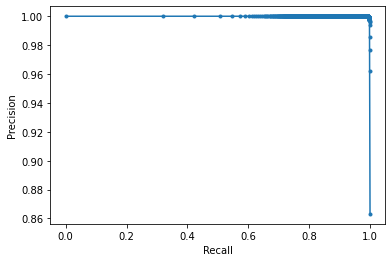

AUC: 1.00
Iteration: 11
[INFO] Starting training phase...
Epoch [279/1000] | loss: 2.0793 (0.3693, 0.3522, 0.0364, 0.6290) | D(x): 0.76 | D(G(x)): 0.25 |  d_loss_val: 0.4815 |

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [1000/1000] | loss: 1.4967 (0.0060, 0.0039, 0.0418, 0.6511) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.9305 |
[INFO] Training phase... Elapsed time: 1126 seconds



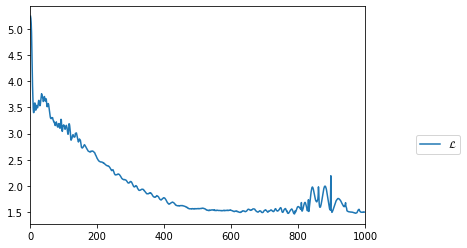

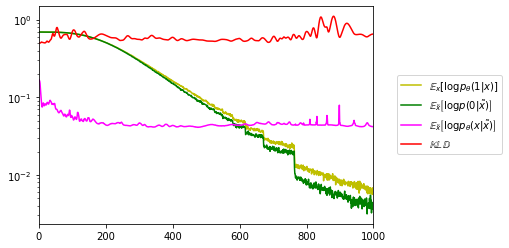

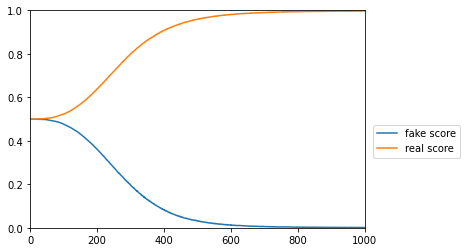

PR AUC: 1.00


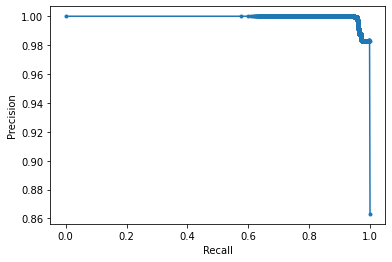

AUC: 1.00
Iteration: 16
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.4522 (0.0022, 0.0025, 0.0389, 0.6697) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.3713 |
[INFO] Training phase... Elapsed time: 1129 seconds



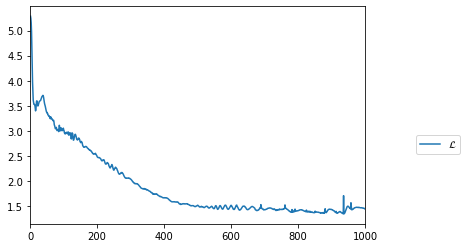

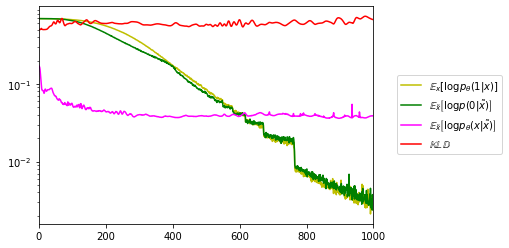

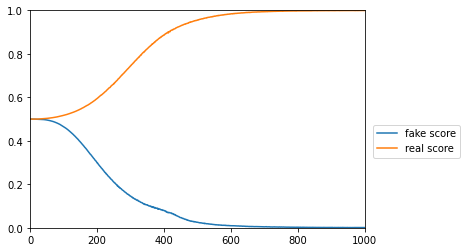

PR AUC: 1.00


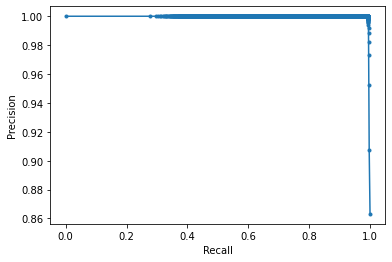

AUC: 1.00
Iteration: 17
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.4442 (0.0036, 0.0026, 0.0392, 0.6544) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.1708 |
[INFO] Training phase... Elapsed time: 1127 seconds



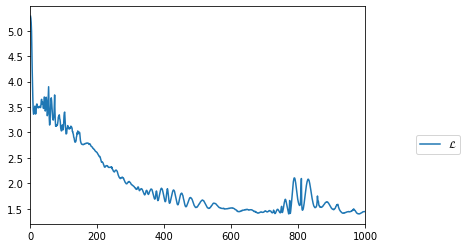

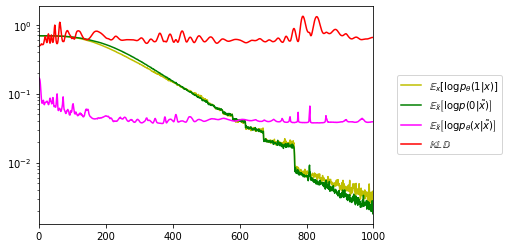

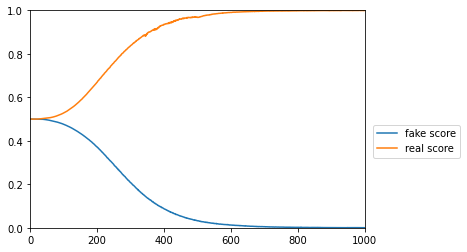

PR AUC: 1.00


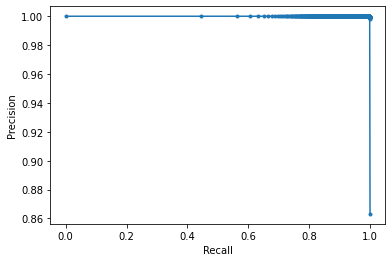

AUC: 1.00
Iteration: 18
[INFO] Starting training phase...
Epoch [454/1000] | loss: 1.6099 (0.0970, 0.1040, 0.0433, 0.5423) | D(x): 0.97 | D(G(x)): 0.05 |  d_loss_val: 0.2499 |

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [1000/1000] | loss: 1.4362 (0.0040, 0.0029, 0.0404, 0.6204) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 1.2215 |
[INFO] Training phase... Elapsed time: 1129 seconds



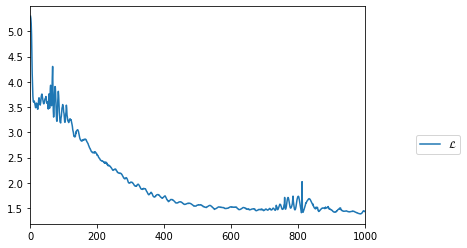

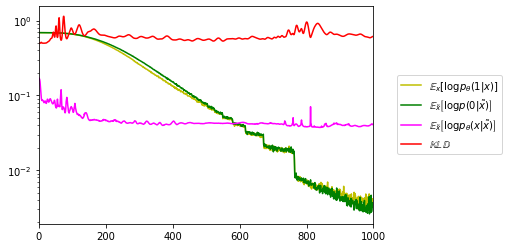

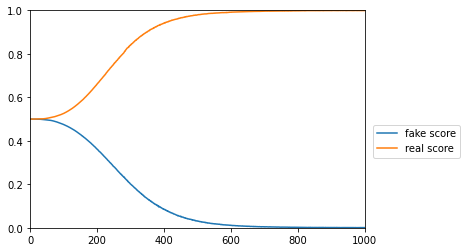

PR AUC: 1.00


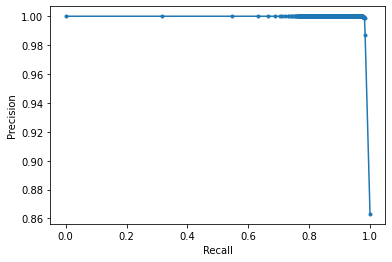

AUC: 0.99
Iteration: 19
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.4022 (0.0036, 0.0031, 0.0397, 0.6017) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 1.4346 |
[INFO] Training phase... Elapsed time: 1245 seconds



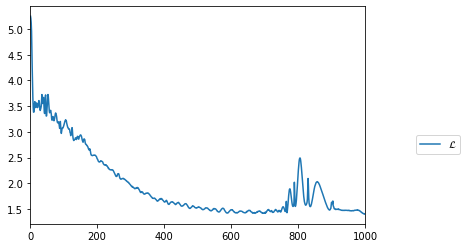

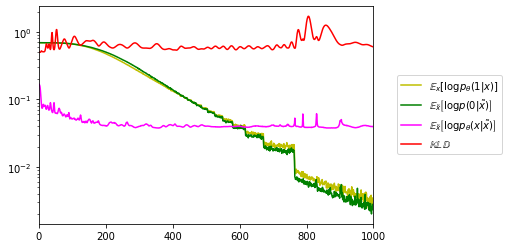

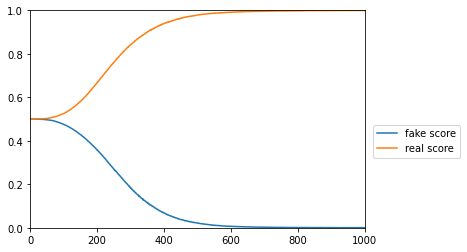

PR AUC: 1.00


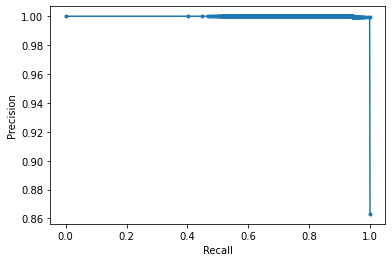

AUC: 1.00
Iteration: 20
[INFO] Starting training phase...
Epoch [1000/1000] | loss: 1.3963 (0.0065, 0.0074, 0.0407, 0.5689) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.3110 |
[INFO] Training phase... Elapsed time: 1252 seconds



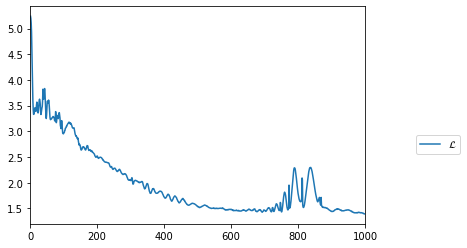

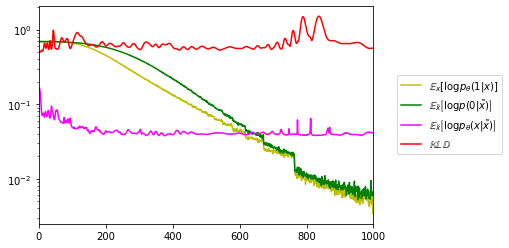

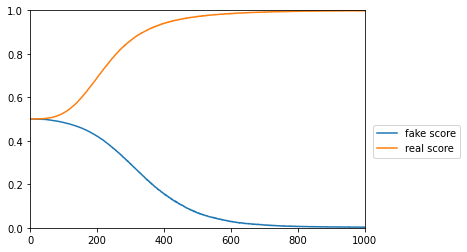

PR AUC: 1.00


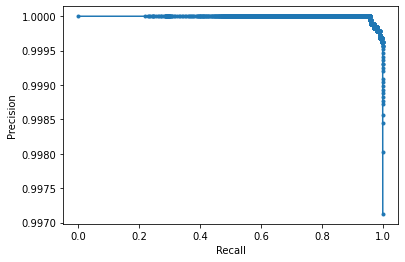

AUC: 1.00


In [5]:
n_runs = 20
auc_list = []
num_epochs = 1000
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_DoH(PATH_B, PATH_M, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = AADNet(device, dataset['selectedColumns'], dataset['discreteCol'], dataset['index'], dataset['x_train'].shape[1])
    
    NAME_D = f'D_GCN_GE_{DATASET}_{i}.ckpt'
    NAME_G = f'G_GCN_GE_{DATASET}_{i}.ckpt'
    
    losses, p_true, p_fake, rec_errors, kldes, real_scores, fake_scores, d_losses_val = trainer.train(train_loader, val_loader, NAME_D, NAME_G, batch_size = batch_size, num_epochs = num_epochs)
    
    trainer.D.load_state_dict(torch.load(os.path.join(SPACE_MODELS, NAME_D)))
    trainer.G.load_state_dict(torch.load(os.path.join(SPACE_MODELS, NAME_G)))
    
    plotLoss(losses, d_losses_val, p_true, p_fake, rec_errors, kldes, real_scores, fake_scores, i, DATASET, show = True)
    
    prediction, y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(1-y_true, 1-yP)
    pr = trainer.pr_auc(1-y_true, 1-yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

In [6]:
meanAUC_PRAUC(auc_list, pr_list, 'GCN_GE_DOH', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.9981360268484991, 0.9748016448467106, 0.9892931812947294, 0.9874443058793799, 0.9132776335544303, 0.9995563007963377, 0.9998014840796214, 0.9926036091798401, 0.9899952305164748, 0.9991924372718254, 0.9746671932642073, 0.9992633095121413, 0.9655319941057576, 0.9993630659401215, 0.9953533281607645, 0.9968953988962002, 0.9995837749039448, 0.9911528792990513, 0.9991543920544916, 0.9999456535386957]
**************
PR AUC:
[0.9997325258939411, 0.9963375915947583, 0.9985345417663741, 0.9982372345422008, 0.9873382606623011, 0.9999307974674219, 0.9999717145554949, 0.998924301876344, 0.998562232960885, 0.9998852310625, 0.9963742568512326, 0.9998891167867269, 0.9952768217106899, 0.9999105746106062, 0.9992773785945354, 0.9995588441142489, 0.9999426870909788, 0.9987713538211809, 0.9998757184996894, 0.9999912551068432]
**************
AUC
0.99 +/- 0.01
95% confidence level, average auc would be between 0.98 and 1.00
**************
PR AUC
1.00 +/- 0.00
95% confidence level, average auc would b

---